In [1]:
import torch
import string
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('train.csv')
df['Response'] = df['Response'].str.replace('\xa0', '')
df.reset_index(drop=True, inplace=True)

# remove nans
sanitized_data = []
for sentence in df["Response"].tolist():
    if type(sentence) != float:
        sanitized_data.append(sentence)

punctuated_text_data = [sentence.lower() for sentence in sanitized_data]
unpunctuated_text_data = [''.join([char for char in sentence if char not in string.punctuation]) for sentence in punctuated_text_data]

In [3]:
# Data Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize unpunctuated text
tokenized_inputs = tokenizer(unpunctuated_text_data, padding=True, truncation=True, return_tensors='pt')

# Tokenize punctuated text
tokenized_labels = tokenizer(punctuated_text_data, padding=True, truncation=True, return_tensors='pt')

# Model Fine-Tuning
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=tokenizer.vocab_size,
    # ignore_mismatched_sizes=True,
)

optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

In [4]:
# Create TensorDatasets
dataset = TensorDataset(tokenized_inputs.input_ids, tokenized_inputs.attention_mask, tokenized_labels.input_ids)

# Train-Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [32]:
num_epochs = 25
losses = []
model.train()
for epoch in trange(num_epochs):
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids.flatten().unsqueeze(dim=1),
            attention_mask=attention_mask.flatten().unsqueeze(dim=1),
            labels=labels.flatten().unsqueeze(dim=1),
        )

        loss = outputs.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

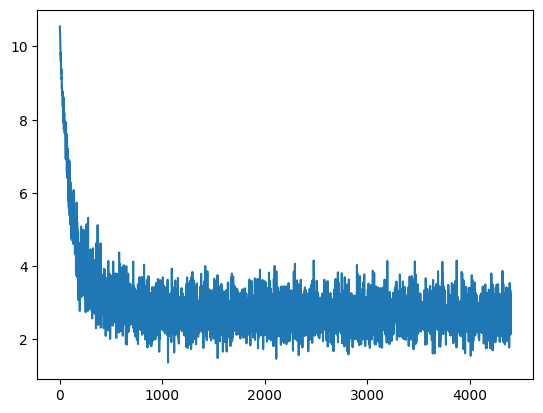

In [33]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [6]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [36]:
test_losses = []
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids.flatten().unsqueeze(dim=1),
            attention_mask=attention_mask.flatten().unsqueeze(dim=1),
            labels=labels.flatten().unsqueeze(dim=1),
        )
        preds = outputs.logits.argmax(dim=-1).reshape(input_ids.shape)
        loss = outputs.loss
        test_losses.append(loss.item())


  0%|          | 0/176 [00:00<?, ?it/s]

In [37]:
np.mean(test_losses)

2.665063326331702

In [38]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0]))

'[CLS] congrats on having a happiness problemgo slowly and tell your partner how you feel as you discover how being loved feelson a deep level you ’ re releasing yourself from interaction patterns which treated you poorly and unkindlytime is needed of repeated occurrences of this newfound loving behavior toward yougradually you will trust more and more that your new living relationship life is your reality [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [39]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(labels[0]))

'[CLS] congrats on having a happiness problem . go slowly and tell your partner how you feel as you discover how being loved feels . on a deep level you ’ re releasing yourself from interaction patterns which treated you poorly and unkindly . time is needed of repeated occurrences of this newfound loving behavior toward you . gradually you will trust more and more that your new living relationship life is your reality . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [40]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(preds[0]))

'[CLS] hi hi . you you . you . . . you . you you you you . . you . you you you . . , to you you . . you . . , . to , you . . . . . . . . . . . . you . . . you .o . you you you you . you you . to . you . you you you you [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [